In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


This notebook investigates the retention rate of users for a mobile game where different groups of users are assigned to different versions of the game with different milestones; one where goals are acheived after 30 levels and the other after 40 levels. The dataset contains unique user information based on which group they were assigned to, the number of rounds played, and whether or not they were still active after 1 and 7 days respectively.

The investigation here is interested in understanding which game format has the highest impact on user retention. The retention for each milestone category will be determined by the number of users that continued playing up to or past the 7 day mark. Additionally, the number of rounds played by each user allows us to assess whether a particular milestone had a greater impact on the engagement of users with the game.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
df[df.duplicated() == True]

,userid,version,sum_gamerounds,retention_1,retention_7


There are no duplicate values for any users across any of the features in the dataset.

In [5]:
df.any().isnull()

userid            False
version           False
sum_gamerounds    False
retention_1       False
retention_7       False
dtype: bool

Furthermore, there is no missing information in any of the columns.

In [6]:
df.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [7]:
def label_figure(ax, spacing=5):
    for rect in ax.patches:
        y_val = rect.get_height()
        x_val = rect.get_x() + rect.get_width() /2
        space = spacing
        va = 'bottom'
        if y_val < 0:
            space*= -1
            va = 'top'
        label = '{:.2f}'.format(y_val)
        ax.annotate(
            label,
            (x_val,y_val),
            xytext = (0,space),
            textcoords='offset points',
            ha = 'center',
            va=va            
        )

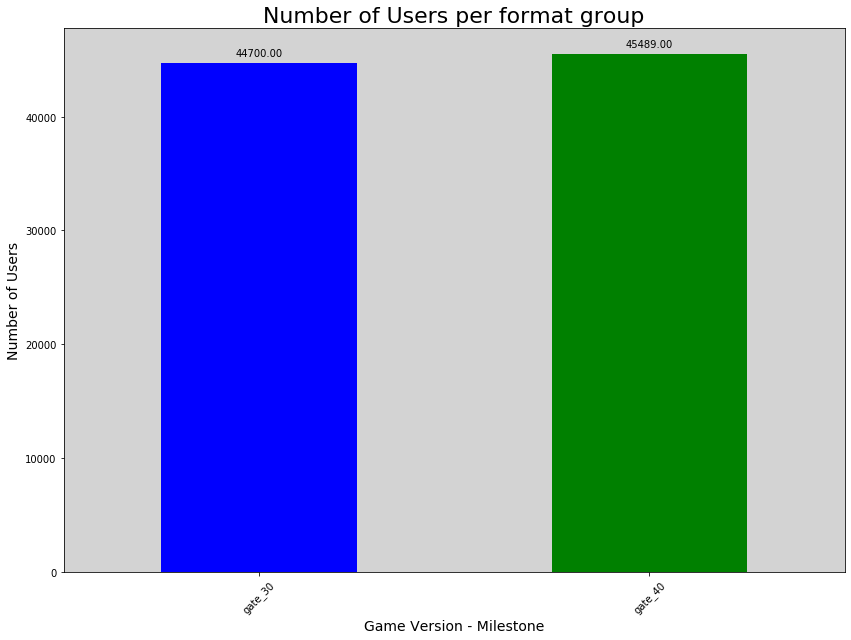

In [8]:
_, ax = plt.subplots(1,1,figsize=(14,10))
ax.set_facecolor('lightgray')
df.groupby('version')['userid'].count().plot(ax=ax, kind='bar', color=['blue','green'])
plt.title('Number of Users per format group', fontsize='22')
plt.xticks(rotation=45, horizontalalignment="center")
plt.ylabel('Number of Users', fontsize='14')
plt.xlabel('Game Version - Milestone', fontsize='14')
label_figure(ax)
plt.show()

The number of users assigned to each game version are roughly equal.

In [9]:
from scipy.stats import chisquare

chisquare([44700,45489], f_exp = [45095, 45095])

Power_divergenceResult(statistic=6.902339505488413, pvalue=0.008608302912290668)

Assuming $\alpha = 0.001$ there is no evidence of Sample Ratio Missmatch when assuming equal sample sizes. Thus we can reject the notion that there is any evidence of SRM in the data. 

In [14]:
from statsmodels.stats.power import TTestIndPower
effect = 0.03
alpha = 0.05
power = 0.8

analysis = TTestIndPower()

res = analysis.solve_power(effect, power = power, nobs1= None,
ratio=1.0, alpha= alpha)

print('optimal sample size of {:.3f}'.format(round(res)))

optimal sample size of 17443.000


In [15]:
sdf = df.sample(n=17443*2,random_state=1)

In [16]:
retention_1day = pd.crosstab([sdf.version],sdf.retention_1,margins=False)
retention_7day = pd.crosstab([sdf.version],sdf.retention_7, margins=False)

In [17]:
from scipy.stats import chi2_contingency

In [18]:
chi2_contingency(retention_1day)

(2.245710995205697,
 0.13398531121203436,
 1,
 array([[9598.03660494, 7674.96339506],
        [9786.96339506, 7826.03660494]]))

In [19]:
retention_1day

retention_1,False,True
version,,
gate_30,9528,7745
gate_40,9857,7756


In [20]:
chi2_contingency(retention_7day)

(5.107519918026027,
 0.023822350464475867,
 1,
 array([[14052.69408932,  3220.30591068],
        [14329.30591068,  3283.69408932]]))

In [21]:
retention_7day

retention_7,False,True
version,,
gate_30,13970,3303
gate_40,14412,3201


After one day there doesn't appear to be any notable difference in the retention rate between groups, but there does seem to be an impact in whether the gate is set to 30 or 40 levels in the retention rate after 7 days. To better understand this it is important to look at the frequency of games played by users over this period of time.

In [22]:
sdf.groupby(['version'])['userid'].count()

version
gate_30    17273
gate_40    17613
Name: userid, dtype: int64

## SRM

In [23]:

chisquare([17273,17613], f_exp = [17443,17443])

Power_divergenceResult(statistic=3.3136501748552427, pvalue=0.06870672264778349)

Assuming a critical value of 0.001 for determining if there is evidence of SRM in the random sampling, we reject the notion that there is any influence/evidence of SRM in the sampled data.

In [24]:
freq_df = pd.DataFrame({'g30': pd.Series(sdf[sdf.version == 'gate_30'].sum_gamerounds.tolist()),'g40':pd.Series(sdf[sdf.version == 'gate_40'].sum_gamerounds.tolist())})
freq_df.describe()

,g30,g40
count,17273.000000,17613.000000
mean,50.822845,50.606370
std,100.868116,103.047419
min,0.000000,0.000000
25%,5.000000,5.000000
50%,17.000000,16.000000
75%,50.000000,51.000000
max,2156.000000,2640.000000


In [25]:
 np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

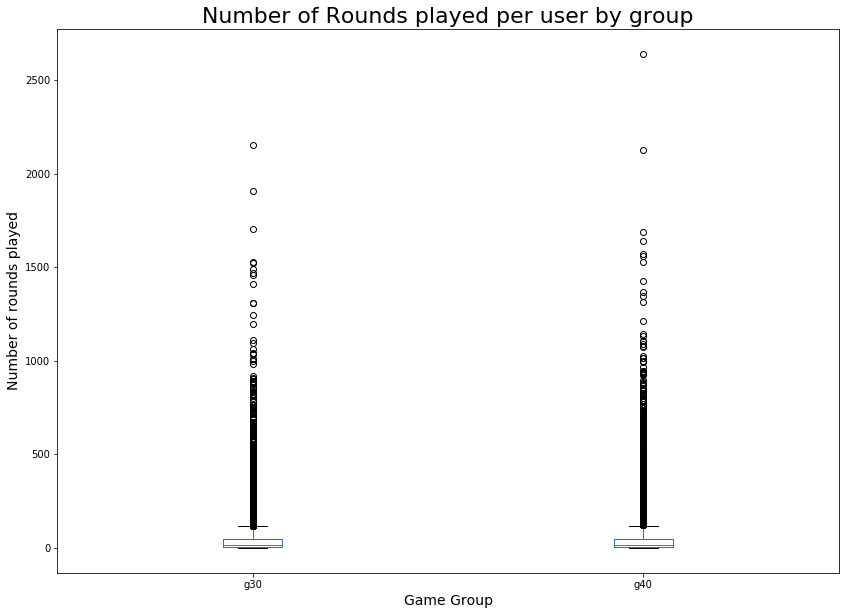

In [26]:

freq_df.plot(kind='box', figsize=(14,10))
plt.title('Number of Rounds played per user by group', fontsize='22')
plt.xlabel('Game Group', fontsize='14')
plt.ylabel('Number of rounds played', fontsize='14')
plt.show()

Looking at a random sample of data points from the original dataset we see fairly similar distributions between groups that appear to be left skewed with long tails in the number of round played per user in each group.

In [27]:
rndstats = sdf.groupby(['sum_gamerounds'])['userid'].count()
total = rndstats.sum()
lt30 = rndstats[:30].sum()
lt40 = rndstats[:40].sum()

print('{:.2%} of players ({}) did not play 30 levels in the first week, and {:.2%} of players ({}) did not play 40 levels in the first week'.format((lt30/total),lt30,(lt40/total),lt40))

63.61% of players (22190) did not play 30 levels in the first week, and 69.96% of players (24405) did not play 40 levels in the first week


In [28]:
grpA = sdf[sdf.version == 'gate_30'].sum_gamerounds
grpB = sdf[sdf.version == 'gate_40'].sum_gamerounds

In [29]:
print(grpA.skew(), grpA.kurtosis())
print(grpB.skew(), grpB.kurtosis())

5.740995606642815 57.167657668395975
6.26274943204305 72.10573563884277


We confirm the visual inpection from earlier that both distributions are highly left skewed with long tails.

In [30]:
from scipy.stats import mannwhitneyu

mannwhitneyu(grpA,grpB)

MannwhitneyuResult(statistic=150463060.5, pvalue=0.03947100330364335)

Confirmation of the difference between groups in the sample is confirmed through the MannWhitneyU test.

In [31]:
sdf.groupby(['version'])['retention_1'].mean()

version
gate_30    0.448388
gate_40    0.440357
Name: retention_1, dtype: float64

In [32]:
sdf.groupby(['version'])['retention_7'].mean()

version
gate_30    0.191223
gate_40    0.181741
Name: retention_7, dtype: float64

At the end of the first week there appears to be a 1% retention in users when the game version has gates set at 30 levels vs gates set at 40 levels.

In [33]:
b1_means = []

for i in range(10000):
    bsamp = sdf.sample(frac=1, replace=True).groupby(['version'])['retention_1'].mean()
    b1_means.append(bsamp)
bmean = pd.DataFrame(b1_means)
bmean.head()

version,gate_30,gate_40
retention_1,0.445073,0.440945
retention_1,0.451675,0.438507
retention_1,0.446697,0.436740
retention_1,0.446727,0.440319
retention_1,0.447641,0.440391


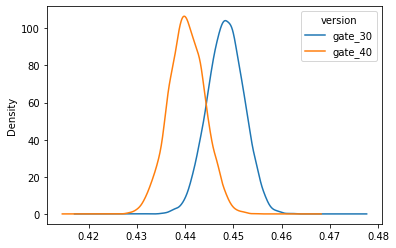

In [34]:
bmean.plot(kind='kde')

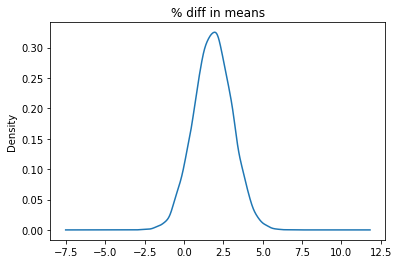

In [35]:
bmean['diff'] = (bmean['gate_30'] - bmean['gate_40'])/bmean['gate_40']*100
bmean['diff'].plot(kind='kde', title='% diff in means')

In [36]:
bmean[bmean['diff'] > 0]

version,gate_30,gate_40,diff
retention_1,0.445073,0.440945,0.936308
retention_1,0.451675,0.438507,3.002841
retention_1,0.446697,0.436740,2.279779
retention_1,0.446727,0.440319,1.455435
retention_1,0.447641,0.440391,1.646234
...,...,...,...
retention_1,0.443941,0.441265,0.606457
retention_1,0.445899,0.442360,0.800010
retention_1,0.459459,0.440690,4.259198
retention_1,0.453330,0.441472,2.686128


In [37]:
(bmean['diff'] >0).sum()/len(bmean)

0.935

In [38]:
bmean.describe()

version,gate_30,gate_40,diff
count,10000.000000,10000.000000,10000.000000
mean,0.448401,0.440337,1.838695
std,0.003747,0.003745,1.211712
min,0.432219,0.427957,-2.688169
25%,0.445879,0.437802,1.024655
50%,0.448416,0.440292,1.838196
75%,0.450955,0.442899,2.657420
max,0.462505,0.454788,6.989316


The mean of the means is in-line with the expectation that they are pulled from a normal distribution with a mean roughly equal to the mean originally observed.

In [39]:
b7_means = []

for i in range(10000):
    bsamp = sdf.sample(frac=1, replace=True).groupby(['version'])['retention_7'].mean()
    b7_means.append(bsamp)
bmean7 = pd.DataFrame(b7_means)
bmean7.head()

version,gate_30,gate_40
retention_7,0.190197,0.185660
retention_7,0.187413,0.187977
retention_7,0.186930,0.182305
retention_7,0.192808,0.183850
retention_7,0.198751,0.188598


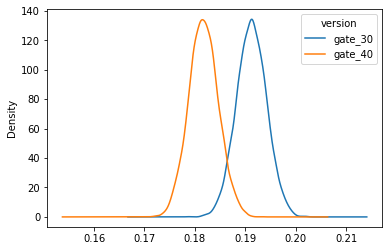

In [40]:
bmean7.plot(kind='kde')

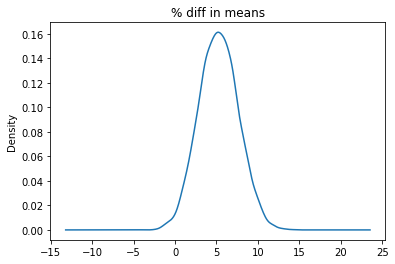

In [41]:
bmean7['diff'] = (bmean7['gate_30'] - bmean7['gate_40'])/bmean7['gate_40']*100
bmean7['diff'].plot(kind='kde', title='% diff in means')

In [42]:
bmean7[bmean7['diff'] >0]

version,gate_30,gate_40,diff
retention_7,0.190197,0.185660,2.443785
retention_7,0.186930,0.182305,2.537072
retention_7,0.192808,0.183850,4.872458
retention_7,0.198751,0.188598,5.383523
retention_7,0.184586,0.183183,0.765854
...,...,...,...
retention_7,0.187696,0.178693,5.038303
retention_7,0.189337,0.183850,2.984389
retention_7,0.194730,0.185420,5.021069
retention_7,0.187773,0.180535,4.009340


In [43]:
(bmean7['diff'] >0).sum()/len(bmean7)

0.9887

In [44]:
bmean7.describe()

version,gate_30,gate_40,diff
count,10000.000000,10000.000000,10000.000000
mean,0.191242,0.181737,5.257759
std,0.002981,0.002931,2.375891
min,0.178567,0.166876,-4.009194
25%,0.189235,0.179750,3.619589
50%,0.191257,0.181699,5.235064
75%,0.193256,0.183681,6.860793
max,0.202267,0.193193,14.339790


## Conclusion:

From this we can take away that in the case of retention and user engagement after 1-day: the game version with gates set at 30-levels is slightly more effective at improving retention 93% of the time.

In the case of 7-day retention when gates are set every 30-levels there is a ~1% increase in user retention 99% of the time.

## Further consideration:

What other benefits come from this increase in user retention? Is a 1% change in retention after the first week a significant enough improvement to warrant full implementation?